## Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from codebase.models.model3 import model3
from codebase.train import train, dataset_token, custom_collate, plot_losses, tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.8)

Usando dispositivo: cuda


In [2]:
# cargamos los datos 100k
data = pd.read_csv('data/es-es_LF_100k.txt', sep='\t', header=None, on_bad_lines='skip')
filtered_vocab = np.load('data/sub_vocab.npy').tolist()
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,las compañías que los venden afirman que son u...,los vivos que los largan aseguran que son un m...
1,academias y escuelas en quart de poblet página...,los colegios y las escuelas en quart de poblet...
2,existen varias áreas recreativas como la del m...,"hay varios chongos para reventar la tarde, com..."
3,moldeo por inyección de plástico,meterle el plástico a presión
4,"el equipo descendió a segunda división, quedan...","el cuadro se fue al tacho a la b, quedando emp..."


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['spanish'], data['lunfardo'],
                                                  test_size=0.1, random_state=28)

train_dataset = dataset_token(X_train, y_train)
val_dataset = dataset_token(X_val, y_val)

print('Primer elemento del dataset de entrenamiento:', train_dataset[1])

Primer elemento del dataset de entrenamiento: {'input': tensor([  101, 95958, 10155, 65407, 21585, 12022, 11031,   119,   102],
       device='cuda:0'), 'target': tensor([  101,   173, 95958, 10155, 65407, 21585, 10102, 10106, 17624, 10278,
          106,   102], device='cuda:0'), 'input_length': tensor(9, device='cuda:0'), 'target_length': tensor(12, device='cuda:0')}


## Intento 1
Tiene que poder memorizar 10 muestras para empezar

In [4]:
# Inicializa el modelo 
model = model3(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


In [5]:
BATCH_SIZE = 10
NUM_EPOCHS = 500
LR = 1e-3

data_overfit = data.head(BATCH_SIZE)
dataset_overfit = dataset_token(data_overfit['spanish'], data_overfit['lunfardo'])
loader_overfit = DataLoader(dataset_overfit, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train(model, loader_overfit, epoch_max=NUM_EPOCHS, lr=LR)

Iniciando entrenamiento...
--------------------------------------------------


c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Entrenamiento completado! Tiempo total: 0.44 minutos


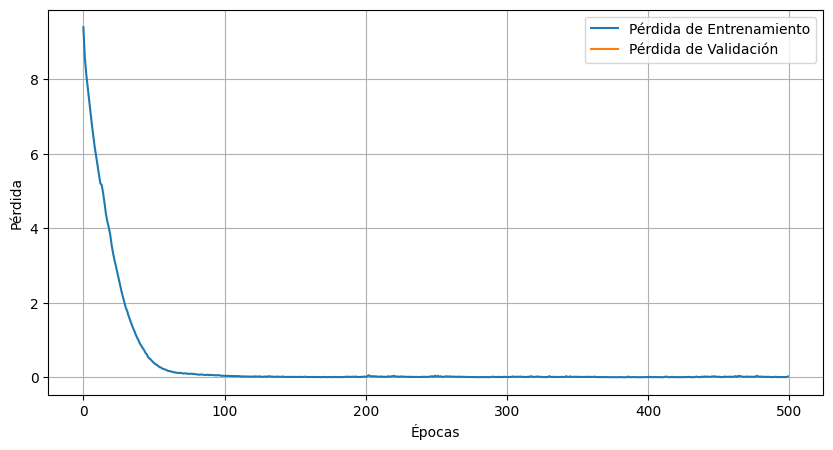

In [6]:
plot_losses(train_loss, val_loss)

In [7]:
def generate_target(dataset, IDX):
    input_IDX = dataset[IDX]['input']
    target_IDX = dataset[IDX]['target']
    target_pred_IDX = model.generate(input_IDX)
    print(tokenizer.decode(input_IDX))
    print(tokenizer.decode(target_IDX))
    print(tokenizer.decode(target_pred_IDX))

generate_target(dataset_overfit, IDX=0)

[CLS] las companias que los venden afirman que son un bien para la salud porque sus compuestos se presentan en concentraciones muy inferiores respecto a los tradicionales. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]


In [8]:
generate_target(dataset_overfit, IDX=1)

[CLS] academias y escuelas en quart de poblet pagina quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]


In [9]:
generate_target(dataset_overfit, IDX=2)

[CLS] existen varias areas recreativas como la del molino de pedroso que cuenta tambien con camping, la de la picota, en el coto y la presa del rey en jubia. existe tambien un parque urbano a orillas del rio freixeiro, junto al que se ha construido una de las mas grandes urbanizaciones de la comarca. naron cuenta con dos centros comerciales. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tam

In [10]:
generate_target(dataset_overfit, IDX=9)

[CLS] de esta manera el movimiento mapuche ingreso a la escena publica chilena, entremezclandose con la politica y sus partidos aunque siempre conservando su especificidad. [SEP]
[CLS] asi, sin anestesia, los mapuches se mandaron a la vidriera chilena, mechiendose con los gambas y sus partuzas, pero sin perder la posta de lo suyo. [SEP]
[CLS] asi, sin anestesia, los mapuches se mandaron a la vidrieraulas lo suyo. [SEP]


## Intento 2

In [11]:
# Inicializa el modelo 
model = model3(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


In [12]:
BATCH_SIZE = 64 #*2
NUM_EPOCHS = 5
LR = 1e-3

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

train_loss, val_loss = train(model, train_dataset, val_dataset, epoch_max=NUM_EPOCHS, lr=LR, verbose_each=1)

Iniciando entrenamiento...
--------------------------------------------------


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [ ]:
plot_losses(train_loss, val_loss)